In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cartopy
import cartopy.crs as ccrs
import matplotlib
%matplotlib inline
from netCDF4 import Dataset


import iris
import iris.plot as iplt
import iris.quickplot as qplt
from iris.coords import DimCoord
from iris.cube import Cube
import matplotlib.colors as colors
from sklearn import datasets
import iris.analysis
import numpy.ma as ma

import matplotlib.ticker as mticker
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point


from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

import matplotlib.cm as mpl_cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


import math
from matplotlib import mlab

import warnings
warnings.filterwarnings("ignore")

import tarfile
import os

In [2]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-1-1-LR',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['BCC-CSM1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']
               
              
#expand out the provided data if there isn't already something there
if not os.path.exists('../data_netcdf/piControl'):
   tar = tarfile.open("../data_netcdf/PMIP4_tas_pr_data.tar.gz")
   tar.extractall(path='../data_netcdf/')
               



In [3]:
#No change needs here
#This cell defines the functions to find variables, models and experiments


#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "../data_netcdf/"
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "../data_netcdf/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='../data_netcdf/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames

#Give the permission to load find_experiment_ensemble_members.bash
#!chmod 700 ../bin/find_experiment_ensemble_members.bash
#This function will identify models in the ensemble
#def identify_ensemble_members(variable_name,experiment_name):
#    datadir="../data_netcdf/%s" %(experiment_name)
#    ensemble_members=!../bin/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
#    return ensemble_members
def identify_ensemble_members(variable_name,experiment_name):
    datadir="../data_netcdf/%s" %(experiment_name)
    ensemble_members = [] #create an empty list
    with os.scandir(datadir) as entries:
        for entry in entries:
            this_file=xr.open_dataset(entry,decode_times=False)
            if variable_name in list(this_file.keys()):
                ensemble_members.append(datadir+"/"+entry.name)
            this_file.close()
    return ensemble_members
#This function will list extract model name
def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

#This function will collect member models which have the variable in the experiment
def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    




## load the 'amoc_mean_ann' variable in the mid-Holocene (derived from the CVDP file) using Iris cube 

11 models: CESM2, EC-Earth3-LR, FGOALS-f3-L, FGOALS-g3, GISS-E2-1-G, HadGEM3-GC31-LL, INM-CM4-8, IPSL-CM6A-LR, 
        MPI-ESM1-2-LR, MRI-ESM2-0, NorESM2-LM

However, no CESM2 model at this stage. 
Because for CESM2, we can't load the variable directly with iris cube , as missing data dimensions for multi-valued DimCoord 'latitude'.
For Fgoals-g3, post-processed AMOC data from CVDP is unavailable now, so we will load the data which is downloaded from the Earth System Grid Federation (ESGF; Balaji et al., 2018, available at https://esgf-node.llnl.gov/search/cmip6/) later.

## Regridding

#### most models have dimension coord -- depth & latitude, but some have different coord names
#### EC-Earth3 and HadGEM3 have coord -- depth & grid_latitude
#### IPSL has coord -- vertical W levels & latitude

In [4]:
modellist = ['CESM2',
             'EC-Earth3-LR', 
             'FGOALS-f3-L', 
             'FGOALS-g3', 
             'GISS-E2-1-G', 
             'HadGEM3-GC31-LL', 
             'INM-CM4-8', 
             'IPSL-CM6A-LR', 
             'MPI-ESM1-2-LR', 
             'MRI-ESM2-0', 
             'NorESM2-LM']

In [5]:
sample_points_1 = [('depth', np.linspace(0,6000,61)),
                   ('latitude',  np.linspace(-89.5,89.5,180))]
sample_points_2 = [('depth', np.linspace(0,6000,61)),
                   ('grid_latitude',  np.linspace(-89.5,89.5,180))]
sample_points_3 = [('Vertical W levels', np.linspace(0,6000,61)),
                   ('latitude',  np.linspace(-89.5,89.5,180))]

In [6]:
PI_AMOC_DATA = []
MH_AMOC_DATA = []
DIFF_AMOC_DATA = []

## load the  'amoc_mean_ann' data for CESM2 and then create a new cube to put the data in

In [7]:
# CESM2 midHolocene
filename_3='../data_netcdf/midHolocene/CESM2_midHolocene.cvdp_data.1-700.nc'
mh_cesm=xr.open_dataset(filename_3,decode_times=False)
mh_cesm_amoc_data=mh_cesm.amoc_mean_ann.values
mh_cesm_lev_data=mh_cesm.lev.values
mh_cesm_lat_data=mh_cesm.lat_amoc.values
mh_depth = DimCoord(mh_cesm_lev_data, standard_name='depth', units='m')
mh_latitude = DimCoord(mh_cesm_lat_data, standard_name='latitude', units='degrees')
mh_cube_cesm_amoc = Cube(mh_cesm_amoc_data,dim_coords_and_dims=[(mh_depth, 0), (mh_latitude, 1)])

In [8]:
# CESM2 piControl
filename_4='../data_netcdf/piControl/CESM2_piControl.cvdp_data.701-1200.nc'
pi_cesm=xr.open_dataset(filename_4,decode_times=False)
pi_cesm_amoc_data=pi_cesm.amoc_mean_ann.values
pi_cesm_lev_data=pi_cesm.lev.values
pi_cesm_lat_data=pi_cesm.lat_amoc.values
pi_depth = DimCoord(pi_cesm_lev_data, standard_name='depth', units='m')
pi_latitude = DimCoord(pi_cesm_lat_data, standard_name='latitude', units='degrees')
pi_cube_cesm_amoc = Cube(pi_cesm_amoc_data,dim_coords_and_dims=[(pi_depth, 0), (pi_latitude, 1)])

In [9]:
diff_cube_cesm_amoc = mh_cube_cesm_amoc - pi_cube_cesm_amoc

In [10]:
pi_cesm = pi_cube_cesm_amoc.interpolate(sample_points_1, iris.analysis.Linear()) 

mh_cesm = mh_cube_cesm_amoc.interpolate(sample_points_1, iris.analysis.Linear()) 

diff_cesm = diff_cube_cesm_amoc.interpolate(sample_points_1, iris.analysis.Linear()) 

In [11]:
PI_CESM = ma.filled(pi_cesm[:,90:180].data,np.nan)
MH_CESM = ma.filled(mh_cesm[:,90:180].data,np.nan)
DIFF_CESM = ma.filled(diff_cesm[:,90:180].data,np.nan)

In [12]:
PI_AMOC_DATA.append(PI_CESM)
MH_AMOC_DATA.append(MH_CESM)
DIFF_AMOC_DATA.append(DIFF_CESM)

## load the 'amoc_mean_ann' data for the rest 10 models

In [13]:
AMOC_MODEL = ['CESM2']
mh_var_dict = ensemble_members_dict('amoc_mean_ann','midHolocene')
pi_var_dict = ensemble_members_dict('amoc_mean_ann','piControl')
for gcm in mh_var_dict:
    if gcm in pi_var_dict:
        if gcm in modellist[1:]:
            AMOC_MODEL.append(gcm)
            mh_amoc = iris.load_cube(mh_var_dict.get(gcm),'amoc_mean_ann')
            pi_amoc = iris.load_cube(pi_var_dict.get(gcm),'amoc_mean_ann')
            diff_amoc = mh_amoc - pi_amoc
            if gcm in ['FGOALS-f3-L', 'FGOALS-g3', 'GISS-E2-1-G', 'INM-CM4-8', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM']:
                pi_data = pi_amoc.interpolate(sample_points_1, iris.analysis.Linear())
                mh_data = mh_amoc.interpolate(sample_points_1, iris.analysis.Linear())
                diff_data = diff_amoc.interpolate(sample_points_1, iris.analysis.Linear()) 
            if gcm in ['EC-Earth3-LR', 'HadGEM3-GC31-LL']:
                pi_data = pi_amoc.interpolate(sample_points_2, iris.analysis.Linear())
                mh_data = mh_amoc.interpolate(sample_points_2, iris.analysis.Linear())
                diff_data = diff_amoc.interpolate(sample_points_2, iris.analysis.Linear())                
            if gcm in ['IPSL-CM6A-LR']:
                pi_data = pi_amoc.interpolate(sample_points_3, iris.analysis.Linear())
                mh_data = mh_amoc.interpolate(sample_points_3, iris.analysis.Linear())
                diff_data = diff_amoc.interpolate(sample_points_3, iris.analysis.Linear())
            PI_AMOC = ma.filled(pi_data[:,90:180].data,np.nan)
            MH_AMOC = ma.filled(mh_data[:,90:180].data,np.nan)
            DIFF_AMOC = ma.filled(diff_data[:,90:180].data,np.nan)
            PI_AMOC_DATA.append(PI_AMOC)
            MH_AMOC_DATA.append(MH_AMOC)
            DIFF_AMOC_DATA.append(DIFF_AMOC)

In [14]:
AMOC_MODEL

['CESM2',
 'NorESM2-LM',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-LR',
 'GISS-E2-1-G',
 'EC-Earth3-LR',
 'INM-CM4-8',
 'MRI-ESM2-0',
 'HadGEM3-GC31-LL']

### compute the ensemble mean AMOC (change)

In [15]:
# ensemble mean change
diff_amoc_ave = np.mean(np.array(DIFF_AMOC_DATA),axis=0)
# put back the data into one of the regridded models in order to use its dimension coordinates for further plotting
diff_amoc_ave_1 = pi_cesm[:,90:180].copy(data=diff_amoc_ave)

In [16]:
# ensemble mean AMOC in PI
# This will be shown as black contours in the plot later for locating the maximum AMOC strength

pi_amoc_ave = np.mean(np.array(PI_AMOC_DATA),axis=0)
# put back the data into one of the regridded models in order to use its dimension coordinates for further plotting
pi_amoc_ave_1 = pi_cesm[:,90:180].copy(data=pi_amoc_ave)

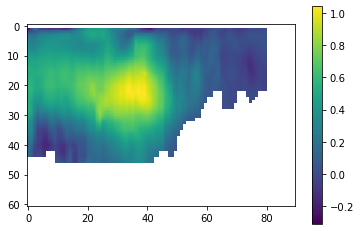

In [17]:
plt.imshow(diff_amoc_ave_1.data)
plt.colorbar()


## plotting the ensemble mean AMOC changes (MH - PI) 

In [96]:
re_depth = np.linspace(0,6000,61)
re_lat = np.linspace(-89.5,89.5,180)

[Text(0.5, 1.0, 'mean (annual) AMOC changes (MH - PI)\n ensemble mean -- 10 PMIP4 models')]

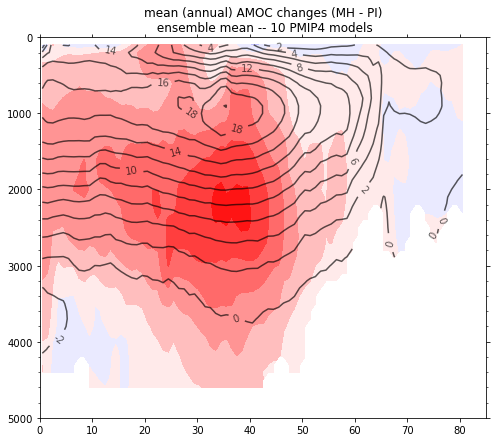

In [106]:
# plotting
fig=plt.figure(figsize=(8,7))
ax=fig.add_subplot(111)

plt.contourf(re_lat[90:180],re_depth,diff_amoc_ave , np.arange(-1.2,1.4,0.2), cmap='bwr')
figure=plt.contour(re_lat[90:180],re_depth,pi_amoc_ave, np.arange(-6,32,2), colors='k',alpha=0.65,linestyles='solid') 

ax.clabel(figure, inline=1, fontsize=10, fmt='%1.0f')

ax.yaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(1000))
#ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(which='both', direction='out', top=True, right=True, labelsize=10.)

# cut the white space:
ax.set_ylim(5000,0) #only show 0-5000m, as 5000-6000m is blank
ax.set_xlim(0,85)   # 85-90N is blank
ax.set(title='mean (annual) AMOC changes (MH - PI)\n ensemble mean -- 10 PMIP4 models')

[Text(0.5, 1.0, 'mean (annual) AMOC changes (MH - PI)\n ensemble mean -- 10 PMIP4 models')]

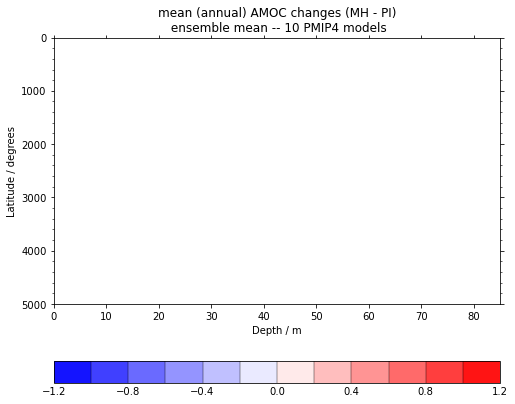

In [107]:
# plotting
fig=plt.figure(figsize=(8,7))
ax=fig.add_subplot(111)

qplt.contourf(diff_amoc_ave_1 , np.arange(-1.2,1.4,0.2), cmap='bwr')
figure=qplt.contour(pi_amoc_ave_1, np.arange(-6,32,2), colors='k',alpha=0.65,linestyles='solid') 

ax.clabel(figure, inline=1, fontsize=10, fmt='%1.0f')

ax.yaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(1000))
#ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.tick_params(which='both', direction='out', top=True, right=True, labelsize=10.)

# cut the white space:
ax.set_ylim(5000,0) #only show 0-5000m, as 5000-6000m is blank
ax.set_xlim(0,85)   # 85-90N is blank
ax.set(title='mean (annual) AMOC changes (MH - PI)\n ensemble mean -- 10 PMIP4 models')